In [1]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 497.5 MB 28 kB/s 
     |████████████████████████████████| 1.4 MB 40.4 MB/s 
     |████████████████████████████████| 462 kB 48.6 MB/s 
     |████████████████████████████████| 15.7 MB 34.9 MB/s 
     |████████████████████████████████| 5.8 MB 22.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:
      Successfully uninstalled tensorflow-2.7.0
ERROR: pip's 

## Carregando dados

In [1]:
# import necessary libraries
from tqdm import tqdm

from time import sleep
import numpy as np
import re
from matplotlib import pyplot as plt

import seaborn as sns

import tensorflow as tf
import tensorflow_text as tf_text
from tensorflow import keras
import tensorflow_hub as hub

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, Bidirectional
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split

Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [2]:
!gdown --id 1mZfnBPCPSV0ZjVClLYZoxHzacZZxU5ZG

Downloading...
From: https://drive.google.com/uc?id=1mZfnBPCPSV0ZjVClLYZoxHzacZZxU5ZG
To: /content/en.zip
100% 2.90M/2.90M [00:00<00:00, 91.1MB/s]


In [3]:
!unzip en.zip

Archive:  en.zip
  inflating: secs0-18-training       
  inflating: secs19-21-development   
  inflating: secs22-24-testing       


In [2]:
sep = '_'
X_train = []
Y_train = []
with open('secs0-18-training', 'r') as file:
    for line in file:
        X_sentence = []
        Y_sentence = []
        for pair in re.split(' ', line):
            if len(pair) > 2:
                token, tag = pair.split(sep)
                tag = tag.strip()
                X_sentence.append(token)
                Y_sentence.append(tag)
        X_train.append(X_sentence)
        Y_train.append(Y_sentence)

In [3]:
sep = '_'
X_val = []
Y_val = []
with open('secs19-21-development', 'r') as file:
    for line in file:
        X_sentence = []
        Y_sentence = []
        for pair in re.split(' ', line):
            if len(pair) > 2:
                token, tag = pair.split(sep)
                tag = tag.strip()
                X_sentence.append(token)
                Y_sentence.append(tag)
        X_val.append(X_sentence)
        Y_val.append(Y_sentence)

In [4]:
sep = '_'
X_test = []
Y_test = []
with open('secs22-24-testing', 'r') as file:
    for line in file:
        X_sentence = []
        Y_sentence = []
        for pair in re.split(' ', line):
            if len(pair) > 2:
                token, tag = pair.split(sep)
                tag = tag.strip()
                X_sentence.append(token)
                Y_sentence.append(tag)
        X_test.append(X_sentence)
        Y_test.append(Y_sentence)

## Preprocessamento dos dados

In [5]:
train_vocabulary = set([word.lower() for sentence in X_train for word in sentence])
# val_vocabulary = set([word.lower() for sentence in X_val for word in sentence])
# test_vocabulary = set([word.lower() for sentence in X_test for word in sentence])

full_vocabulary = len(train_vocabulary.union(set([word.lower() for sentence in X_val for word in sentence])).union(set([word.lower() for sentence in X_test for word in sentence])))

num_tags  = len(set([word.lower() for sentence in Y_train for word in sentence]))

In [6]:
print("Quantidade de sentenças de treino: {}".format(len(X_train)))
print("Quantidade de sentenças de validação: {}".format(len(X_val)))
print("Quantidade de sentenças de teste: {}".format(len(X_test)))
print()
print("Tamanho do vocabulario extraido do treino: {}".format(len(train_vocabulary)))
print("Tamanho do vocabulario total dos dados: {}".format(full_vocabulary))
print("Quantidade de tags possiveis: {}".format(num_tags))

Quantidade de sentenças de treino: 38219
Quantidade de sentenças de validação: 5527
Quantidade de sentenças de teste: 5462

Tamanho do vocabulario extraido do treino: 38574
Tamanho do vocabulario total dos dados: 43766
Quantidade de tags possiveis: 45


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


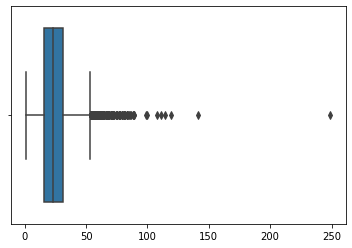

In [7]:
sns.boxplot([len(sentence) for sentence in X_train])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


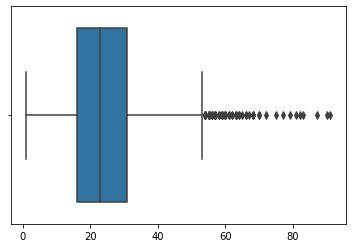

In [21]:
sns.boxplot([len(sentence) for sentence in X_val])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


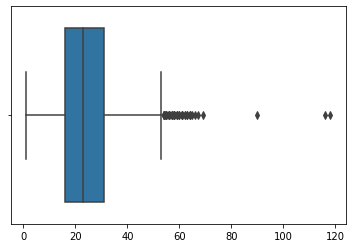

In [22]:
sns.boxplot([len(sentence) for sentence in X_test])
plt.show()

In [8]:
max_len = 100

X_train = [x for x in X_train if len(x) <= max_len]
Y_train = [y for y in Y_train if len(y) <= max_len]

X_val = [x for x in X_val if len(x) <= max_len]
Y_val = [y for y in Y_val if len(y) <= max_len]

X_test = [x for x in X_test if len(x) <= max_len]
Y_test = [y for y in Y_test if len(y) <= max_len]

In [9]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

# word_tokenizer.fit_on_texts(X_val)
# word_tokenizer.fit_on_texts(X_test)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_val = word_tokenizer.texts_to_sequences(X_val)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [10]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y_train)

# tag_tokenizer.fit_on_texts(Y_val)
# tag_tokenizer.fit_on_texts(Y_test)

Y_train = tag_tokenizer.texts_to_sequences(Y_train)
Y_val = tag_tokenizer.texts_to_sequences(Y_val)
Y_test = tag_tokenizer.texts_to_sequences(Y_test)

In [11]:
MAX_SEQ_LENGTH = max_len

X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
Y_train = pad_sequences(Y_train, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")

X_val = pad_sequences(X_val, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
Y_val = pad_sequences(Y_val, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")

X_test = pad_sequences(Y_test, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
Y_test = pad_sequences(Y_test, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")

In [12]:
# use Keras' to_categorical function to one-hot encode Y
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
Y_test = to_categorical(Y_test)

## BERT

In [13]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].


In [14]:
encoder = tf.keras.Model(text_input, pooled_output)

In [ ]:
EMBEDDING_SIZE  = encoder.output_shape[1]
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
words_idx = word_tokenizer.word_index.items()

embedding_weights[[w[1] for w in words_idx], :] = encoder(tf.constant([w[0] for w in words_idx]))

In [ ]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_val.shape))
print('Shape of output sequences: {}'.format(Y_val.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

# 3. Modelo LSTM Bidirecional

In [ ]:
NUM_CLASSES = Y_train.shape[2]
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(tf.keras.layers.BatchNormalization())
bidirect_model.add(Dense(units=32, activation='relu'))
bidirect_model.add(Bidirectional(LSTM(16, return_sequences=True)))
bidirect_model.add(tf.keras.layers.BatchNormalization())
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [ ]:
bidirect_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name="Accuracy"), tf.keras.metrics.Precision(name="Precision"), tf.keras.metrics.Recall(name="Recall")])

In [ ]:
bidirect_model.summary()

In [ ]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['input_1[0][0]']                
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

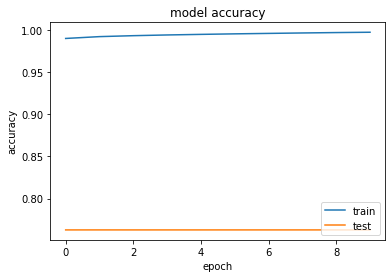

In [ ]:
# visualise training history
plt.plot(bidirect_training.history['Accuracy'])
plt.plot(bidirect_training.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

In [ ]:
loss, accuracy, precision, recall = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0}\nAccuracy: {1}\nPrecision: {2}\nRecall: {3}".format(loss, accuracy, precision, recall))

171/171 [==============================] - 3s 16ms/step - loss: 2.6219 - Accuracy: 0.7629 - Precision: 0.7639 - Recall: 0.7629
Loss: 2.621947765350342
Accuracy: 0.7629486918449402
Precision: 0.7639361619949341
Recall: 0.7629414200782776
